In [1]:
# For Data Processing
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance

# For ML Models
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Miscellaneous
from tqdm import tqdm
import os
import random

In [2]:
train_dir = 'data/Training/'
test_dir = 'data/Testing/'

train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(train_dir+label):
        train_paths.append(train_dir+label+'/'+image)
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)
print(train_labels)

['glioma', 'pituitary', 'notumor', 'glioma', 'pituitary', 'meningioma', 'notumor', 'glioma', 'notumor', 'notumor', 'glioma', 'pituitary', 'notumor', 'pituitary', 'glioma', 'notumor', 'meningioma', 'glioma', 'glioma', 'glioma', 'notumor', 'pituitary', 'pituitary', 'meningioma', 'meningioma', 'glioma', 'pituitary', 'pituitary', 'glioma', 'glioma', 'notumor', 'notumor', 'notumor', 'pituitary', 'notumor', 'glioma', 'glioma', 'notumor', 'pituitary', 'notumor', 'pituitary', 'notumor', 'notumor', 'glioma', 'meningioma', 'pituitary', 'meningioma', 'notumor', 'glioma', 'glioma', 'glioma', 'meningioma', 'meningioma', 'notumor', 'meningioma', 'notumor', 'notumor', 'notumor', 'pituitary', 'notumor', 'notumor', 'glioma', 'notumor', 'notumor', 'pituitary', 'glioma', 'glioma', 'meningioma', 'glioma', 'notumor', 'notumor', 'notumor', 'notumor', 'pituitary', 'pituitary', 'pituitary', 'glioma', 'glioma', 'notumor', 'glioma', 'glioma', 'meningioma', 'glioma', 'pituitary', 'notumor', 'notumor', 'glioma', 

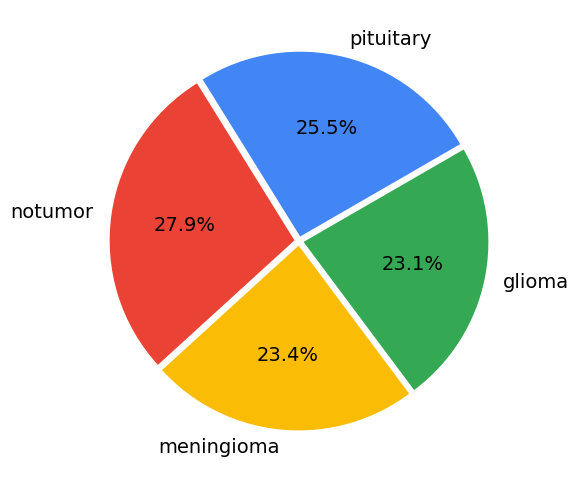

In [3]:
plt.figure(figsize=(14,6))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.rcParams.update({'font.size': 14})
plt.pie([len([x for x in train_labels if x=='pituitary']),
         len([x for x in train_labels if x=='notumor']),
         len([x for x in train_labels if x=='meningioma']),
         len([x for x in train_labels if x=='glioma'])],
        labels=['pituitary','notumor', 'meningioma', 'glioma'],
        colors=colors, autopct='%.1f%%', explode=(0.025,0.025,0.025,0.025),
        startangle=30);

In [4]:
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(test_dir+label):
        test_paths.append(test_dir+label+'/'+image)
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

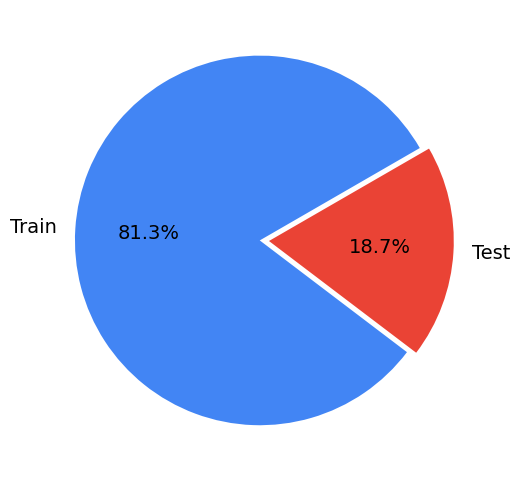

In [5]:
plt.figure(figsize=(14,6))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.rcParams.update({'font.size': 14})
plt.pie([len(train_labels), len(test_labels)],
        labels=['Train','Test'],
        colors=colors, autopct='%.1f%%', explode=(0.05,0),
        startangle=30);

In [6]:
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    image = np.array(image)/255.0
    return image

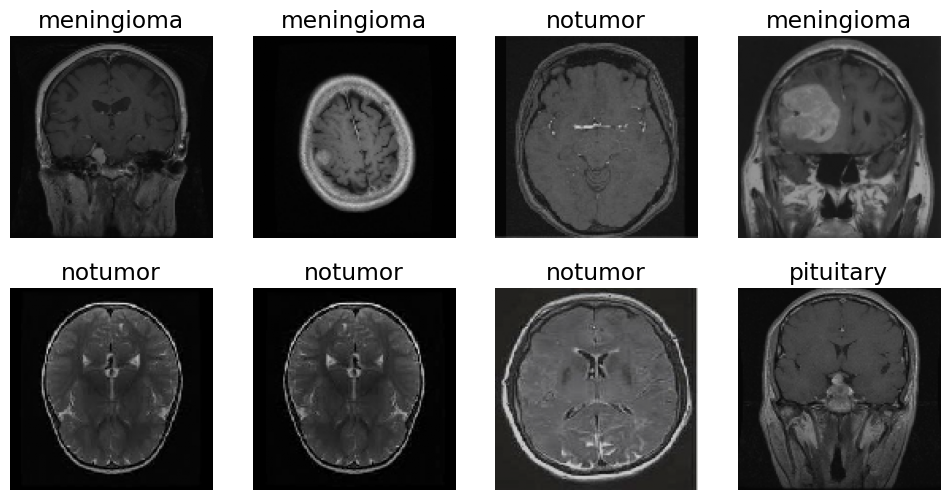

In [7]:
IMAGE_SIZE = 128

def open_images(paths):
    '''
    Given a list of paths to images, this function returns the images as arrays (after augmenting them)
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE,IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

images = open_images(train_paths[50:59])
labels = train_labels[50:59]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 12})
plt.show()

In [8]:
unique_labels = os.listdir(train_dir)

def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

In [9]:
base_model = VGG16(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet')
# Set all layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False
# Set the last vgg block to trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

model = Sequential()
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_labels), activation='softmax'))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 15,763,908
Trainable params: 8,128,644
Non

In [11]:
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [12]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

In [13]:
batch_size = 20
steps = int(len(train_paths)/batch_size)
epochs = 10
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/10
285/285 [==============================] - 663s 2s/step - loss: 0.4539 - sparse_categorical_accuracy: 0.8244
Epoch 2/10
285/285 [==============================] - 549s 2s/step - loss: 0.2215 - sparse_categorical_accuracy: 0.9120
Epoch 3/10
285/285 [==============================] - 731s 3s/step - loss: 0.1586 - sparse_categorical_accuracy: 0.9401
Epoch 4/10
285/285 [==============================] - 910s 3s/step - loss: 0.1061 - sparse_categorical_accuracy: 0.9606
Epoch 5/10
285/285 [==============================] - 547s 2s/step - loss: 0.0804 - sparse_categorical_accuracy: 0.9682
Epoch 6/10
285/285 [==============================] - 442s 2s/step - loss: 0.0908 - sparse_categorical_accuracy: 0.9670
Epoch 7/10
285/285 [==============================] - 3180s 11s/step - loss: 0.0694 - sparse_categorical_accuracy: 0.9747
Epoch 8/10
285/285 [==============================] - 339s 1s/step - loss: 0.0385 - sparse_categorical_accuracy: 0.9874
Epoch 9/10
285/285 [==================

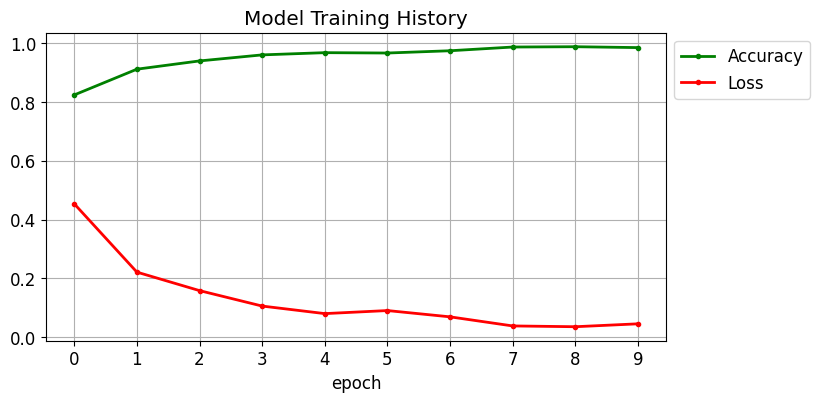

In [14]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [15]:
batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

  0%|                                                                                                                                        | 0/40 [00:00<?, ?it/s]

1/1 [==============================] - 3s 3s/step


  2%|███▏                                                                                                                            | 1/40 [00:03<02:27,  3.77s/it]

1/1 [==============================] - 2s 2s/step


  5%|██████▍                                                                                                                         | 2/40 [00:07<02:14,  3.55s/it]

1/1 [==============================] - 2s 2s/step


  8%|█████████▌                                                                                                                      | 3/40 [00:09<01:46,  2.88s/it]

1/1 [==============================] - 2s 2s/step


 10%|████████████▊                                                                                                                   | 4/40 [00:11<01:32,  2.56s/it]

1/1 [==============================] - 2s 2s/step


 12%|████████████████                                                                                                                | 5/40 [00:13<01:22,  2.36s/it]

1/1 [==============================] - 2s 2s/step


 15%|███████████████████▏                                                                                                            | 6/40 [00:15<01:15,  2.21s/it]

1/1 [==============================] - 2s 2s/step


 18%|██████████████████████▍                                                                                                         | 7/40 [00:17<01:09,  2.10s/it]

1/1 [==============================] - 2s 2s/step


 20%|█████████████████████████▌                                                                                                      | 8/40 [00:19<01:06,  2.06s/it]

1/1 [==============================] - 2s 2s/step


 22%|████████████████████████████▊                                                                                                   | 9/40 [00:21<01:02,  2.02s/it]

1/1 [==============================] - 2s 2s/step


 25%|███████████████████████████████▊                                                                                               | 10/40 [00:22<00:59,  2.00s/it]

1/1 [==============================] - 2s 2s/step


 28%|██████████████████████████████████▉                                                                                            | 11/40 [00:24<00:57,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 30%|██████████████████████████████████████                                                                                         | 12/40 [00:26<00:54,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 32%|█████████████████████████████████████████▎                                                                                     | 13/40 [00:28<00:52,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 35%|████████████████████████████████████████████▍                                                                                  | 14/40 [00:31<00:55,  2.12s/it]

1/1 [==============================] - 2s 2s/step


 38%|███████████████████████████████████████████████▋                                                                               | 15/40 [00:33<00:52,  2.09s/it]

1/1 [==============================] - 2s 2s/step


 40%|██████████████████████████████████████████████████▊                                                                            | 16/40 [00:35<00:49,  2.05s/it]

1/1 [==============================] - 2s 2s/step


 42%|█████████████████████████████████████████████████████▉                                                                         | 17/40 [00:37<00:46,  2.03s/it]

1/1 [==============================] - 2s 2s/step


 45%|█████████████████████████████████████████████████████████▏                                                                     | 18/40 [00:39<00:44,  2.02s/it]

1/1 [==============================] - 2s 2s/step


 48%|████████████████████████████████████████████████████████████▎                                                                  | 19/40 [00:41<00:42,  2.02s/it]

1/1 [==============================] - 2s 2s/step


 50%|███████████████████████████████████████████████████████████████▌                                                               | 20/40 [00:43<00:39,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 52%|██████████████████████████████████████████████████████████████████▋                                                            | 21/40 [00:45<00:37,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████████████████████████████████████████████████████████████████████▊                                                         | 22/40 [00:46<00:34,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████████████████████████████████████████████████████████████████████████                                                      | 23/40 [00:48<00:32,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 60%|████████████████████████████████████████████████████████████████████████████▏                                                  | 24/40 [00:50<00:30,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 62%|███████████████████████████████████████████████████████████████████████████████▍                                               | 25/40 [00:52<00:28,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████████████████████████████████████████████████████████████████████████████████▌                                            | 26/40 [00:54<00:26,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 68%|█████████████████████████████████████████████████████████████████████████████████████▋                                         | 27/40 [00:56<00:23,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 70%|████████████████████████████████████████████████████████████████████████████████████████▉                                      | 28/40 [00:57<00:21,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 72%|████████████████████████████████████████████████████████████████████████████████████████████                                   | 29/40 [00:59<00:20,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 75%|███████████████████████████████████████████████████████████████████████████████████████████████▎                               | 30/40 [01:01<00:18,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 31/40 [01:03<00:17,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 32/40 [01:05<00:15,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 33/40 [01:07<00:13,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 34/40 [01:09<00:11,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 35/40 [01:14<00:13,  2.71s/it]

1/1 [==============================] - 2s 2s/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 36/40 [01:16<00:09,  2.47s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 37/40 [01:18<00:06,  2.32s/it]

1/1 [==============================] - 2s 2s/step


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 38/40 [01:20<00:04,  2.24s/it]

1/1 [==============================] - 2s 2s/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 39/40 [01:22<00:02,  2.14s/it]

1/1 [==============================] - 2s 2s/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [01:24<00:00,  2.14s/it]

1/1 [==============================] - 2s 2s/step


41it [01:26,  2.11s/it]                                                                                                                                             


In [16]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      glioma       1.00      0.86      0.92       300
  meningioma       0.88      0.99      0.93       306
     notumor       1.00      1.00      1.00       405
   pituitary       0.99      0.99      0.99       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.97      0.96      0.96      1311



ValueError: The number of FixedLocator locations (4), usually from a call to set_ticks, does not match the number of labels (9).

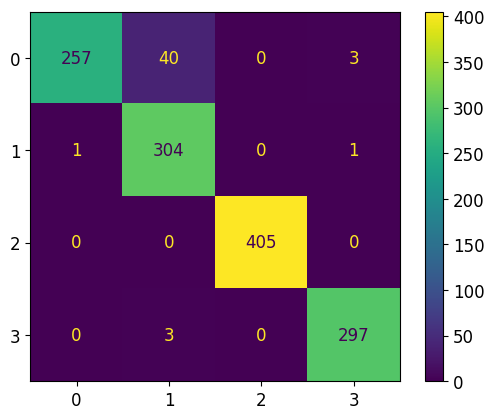

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = labels)
cm_display.plot()
plt.show()

In [18]:
model.save('CancerVGG2.h5')